# plot accuracy for three conditions

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import sys
sys.path.append('../')
from ecog_band.utils import *
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch
from torch.utils import data as Data
from sklearn.model_selection import GridSearchCV,train_test_split
import torch.nn as nn
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import scipy.io as scio
import matplotlib.image as mpimg
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# bands_list = {
#     'delta': (1, 4),
#     'theta': (4, 8),
#     'alpha': (8, 12),
#     'beta': (12, 30),
#     'gamma': (30, 70),
#     'high gamma':(70,150),
#     'else2':(150,min(400/2, 300))
# }
bands_list = ['theta', 'alpha', 'beta1', 'beta2', 'low gamma', 'high gamma']
freq_list=[400]
HS_list=[68, 69, 75, 79, 82, 83, 84, 85, 86]
mpl.rcParams['font.size'] =10

## 1.1 Plot the classification accuracy of all electrodes across subjects, with color intensity indicating accuracy level.

In [13]:
def load_all_subjects_acc_of_sig(HS_list, freq_list, bands_sig_elecs, band):
    all_coords, all_values = [], []
    for HS in HS_list:
        for freq in freq_list:
            save_acc_path = f'/public/DATA/overt_reading/bands_acc/HS{HS}/{freq}'
            bands_acc = np.load(os.path.join(save_acc_path, 'bands_acc.npy'), allow_pickle=True).item()
            band_acc = bands_acc[band]
            subject_str = f"HS{HS}"
            
            # Load 3D electrode coordinates in MNI space
            path = '/public/DATA/overt_reading/'
            coords = scio.loadmat(path + f"/elecs/All_elecs/{subject_str}_warped_elec_pos2D.mat")['elecmatrix']

            for i, acc in enumerate(band_acc):
                if i not in bands_sig_elecs:
                    continue
                all_coords.append(coords[i])  # Append each electrode's coordinates
                all_values.append(acc)        # Append each electrode's accuracy

    return np.array(all_coords), np.array(all_values)

import matplotlib.colors as mcolors
def plot_brain_surface_with_acc(all_coords, all_values, band, task):
    # Load 2D brain image
    norm = mcolors.Normalize(vmin=0, vmax=1)
    img = mpimg.imread('/public/DATA/overt_reading/elecs/Brain2D/MNI152_brain2D.png')
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.scatter(all_coords[:, 0], all_coords[:, 1], c=all_values, cmap='Reds',norm=norm, alpha=0.7)
    # plt.colorbar(label='Accuracy')
    plt.colorbar(label='Accuracy', shrink=0.65, aspect=30)
    plt.title(f'Accuracy of Significant Electrodes across Subjects - {band} - {task}')
    plt.axis('off')
    plt.show()

[242]
[3]
[14, 35]
[172, 3]
[160, 193, 224, 208, 177, 210, 241, 158, 107, 172, 109, 203, 111, 91, 124, 95, 236, 190, 252, 18, 109, 110]
[224, 4, 143, 176, 177, 210, 31, 198, 170, 106, 43, 109, 203, 79, 47, 243, 214, 250, 60, 61, 223, 96, 17, 22, 98, 7, 128, 224, 192, 230, 199, 136, 137, 168, 231, 76, 236, 246, 247, 225, 195, 4, 106, 108, 141, 142, 78, 110, 212, 244, 245, 246, 56, 89, 90, 95]
[201, 150, 139, 32, 7, 141, 142, 15, 31, 94, 159]
[0, 209, 82, 141]
[105, 88, 85]
[105, 100, 173, 102, 3]
[128, 161, 224, 101, 234, 142, 177, 243, 118, 95, 158, 159, 198, 7, 150, 23, 217, 154, 155, 28, 219, 170, 172, 173, 47, 175, 249, 250, 189, 190, 191, 24, 13, 191, 11, 206, 175, 22, 62, 251, 220, 189, 190, 223, 106, 234, 235, 109, 247, 92, 31, 3, 37, 38, 69, 71, 41, 72, 103, 104, 105, 20, 22, 55, 87, 250, 251, 120]
[74, 12, 142, 138, 128, 4, 140, 19, 174, 176, 177, 58, 193, 195, 71, 73, 208, 209, 210, 85, 218, 219, 220, 111, 239, 121, 123, 124, 126, 127, 163, 249, 198, 7, 218, 250, 171, 79, 181,

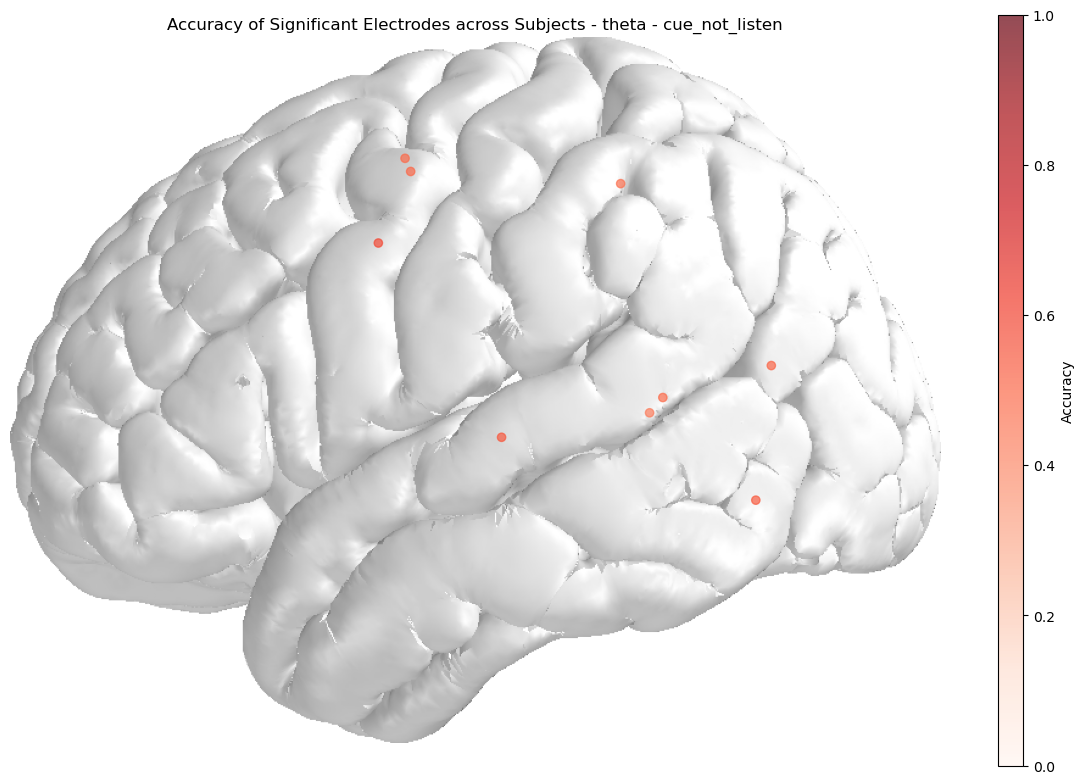

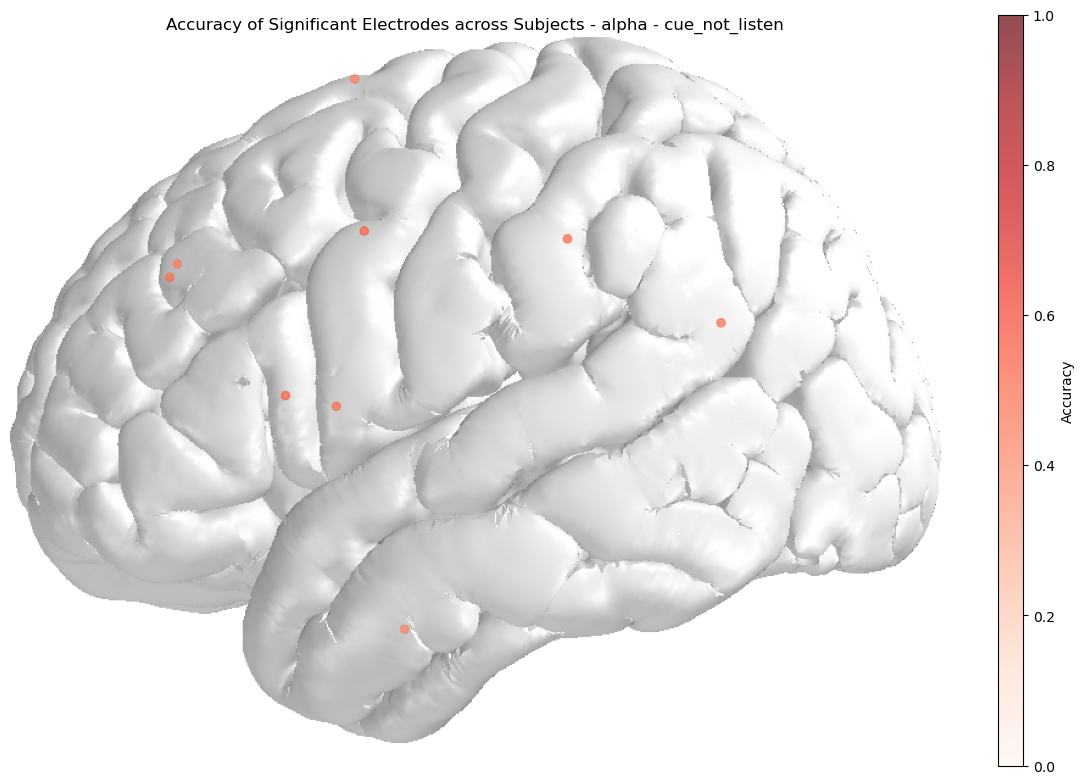

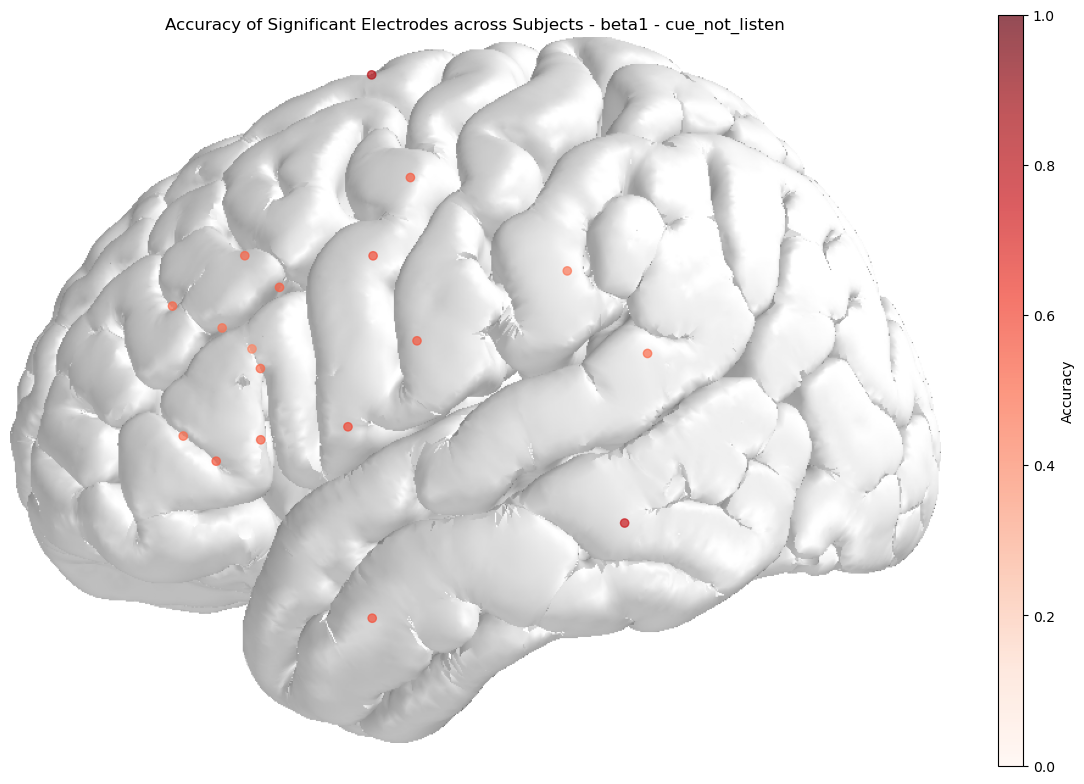

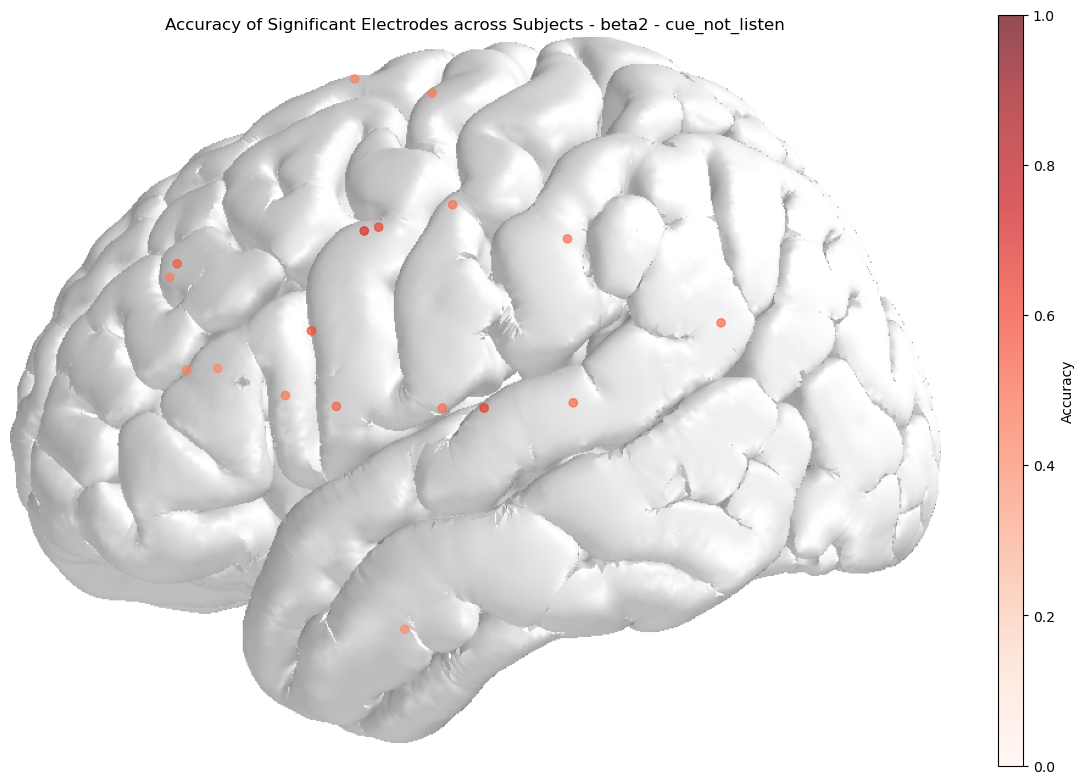

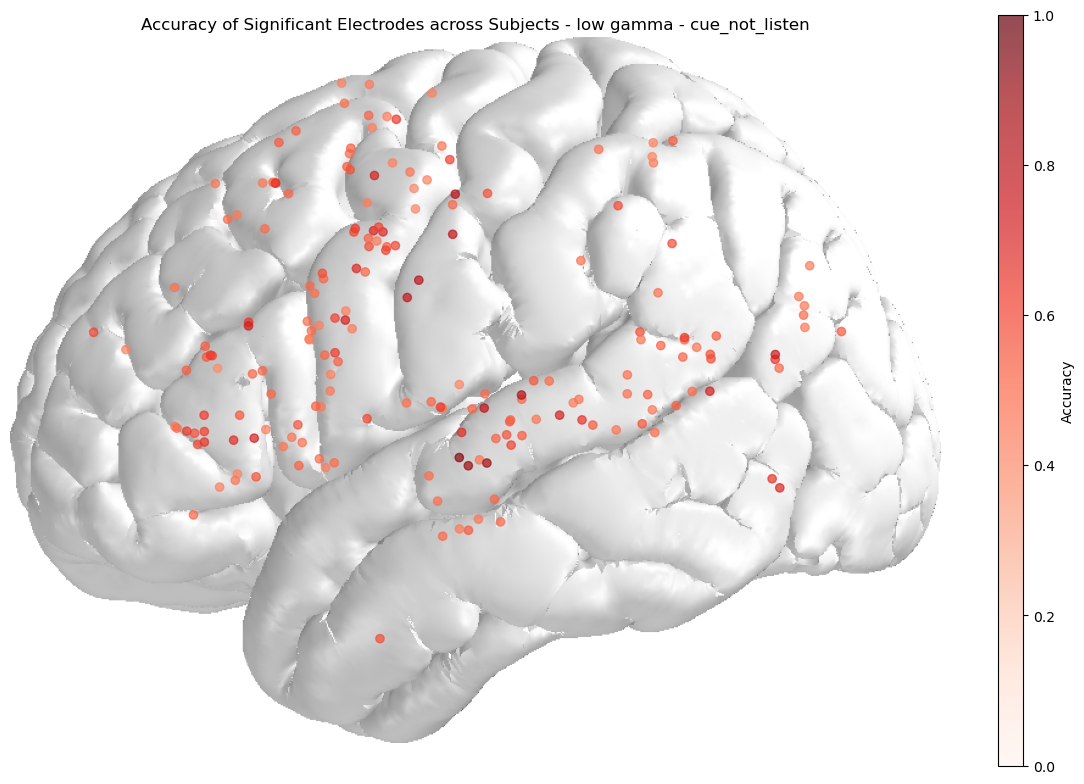

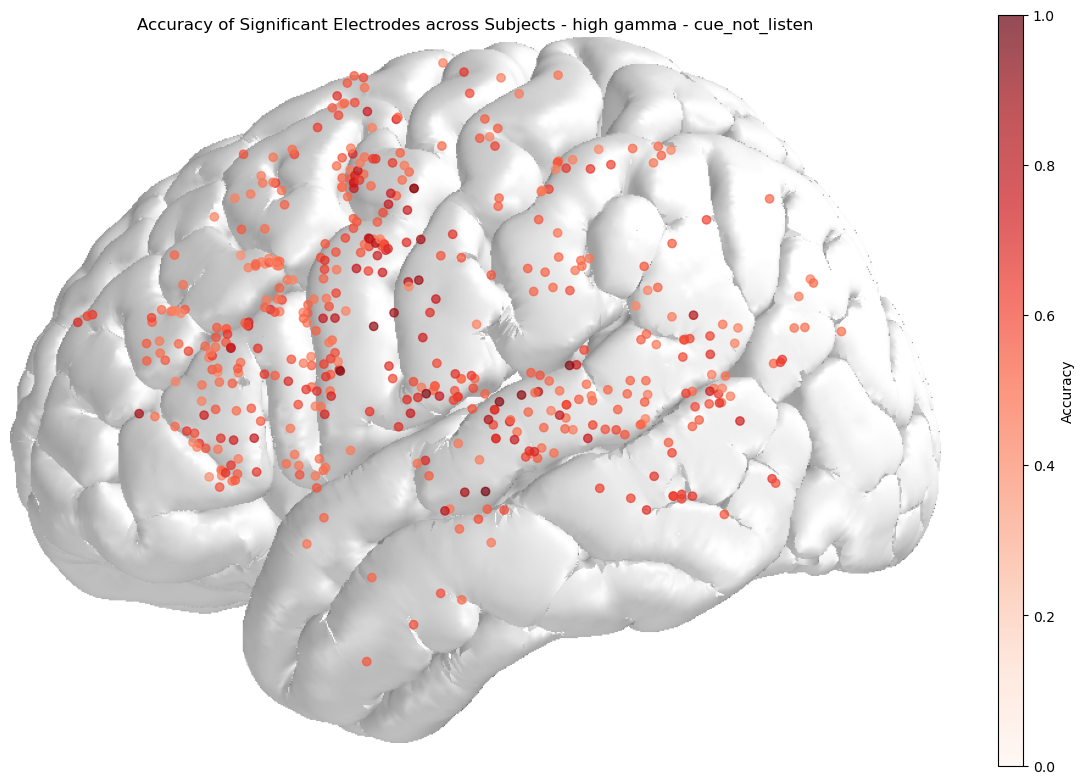

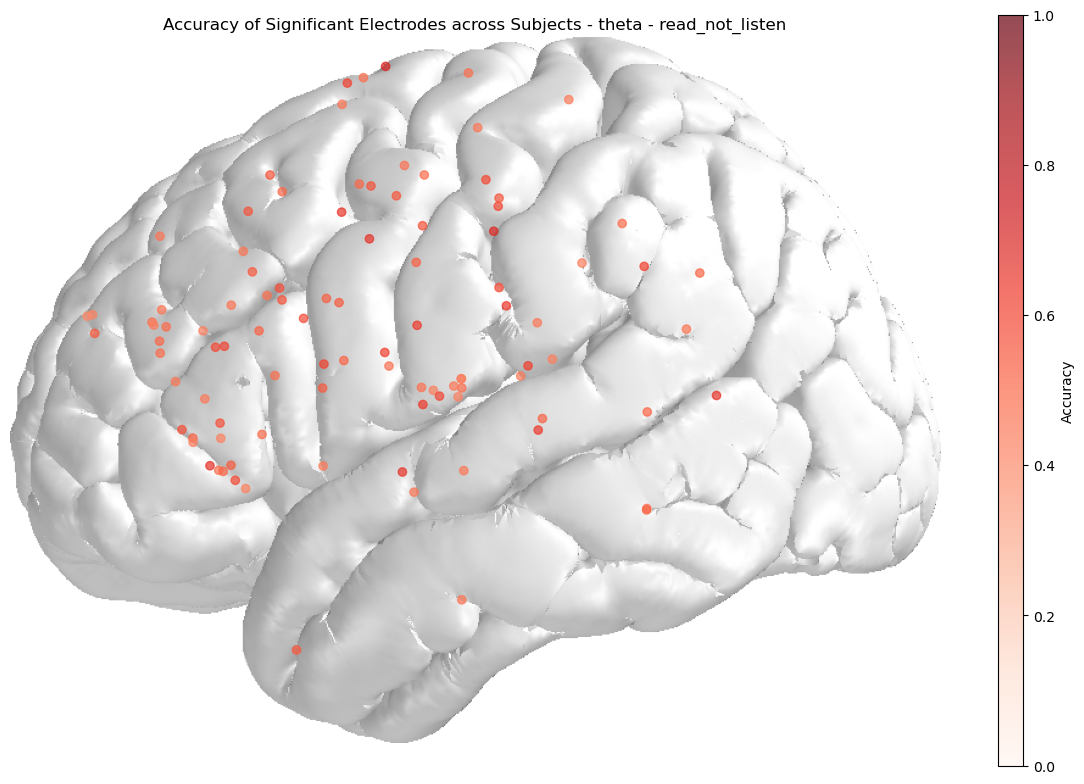

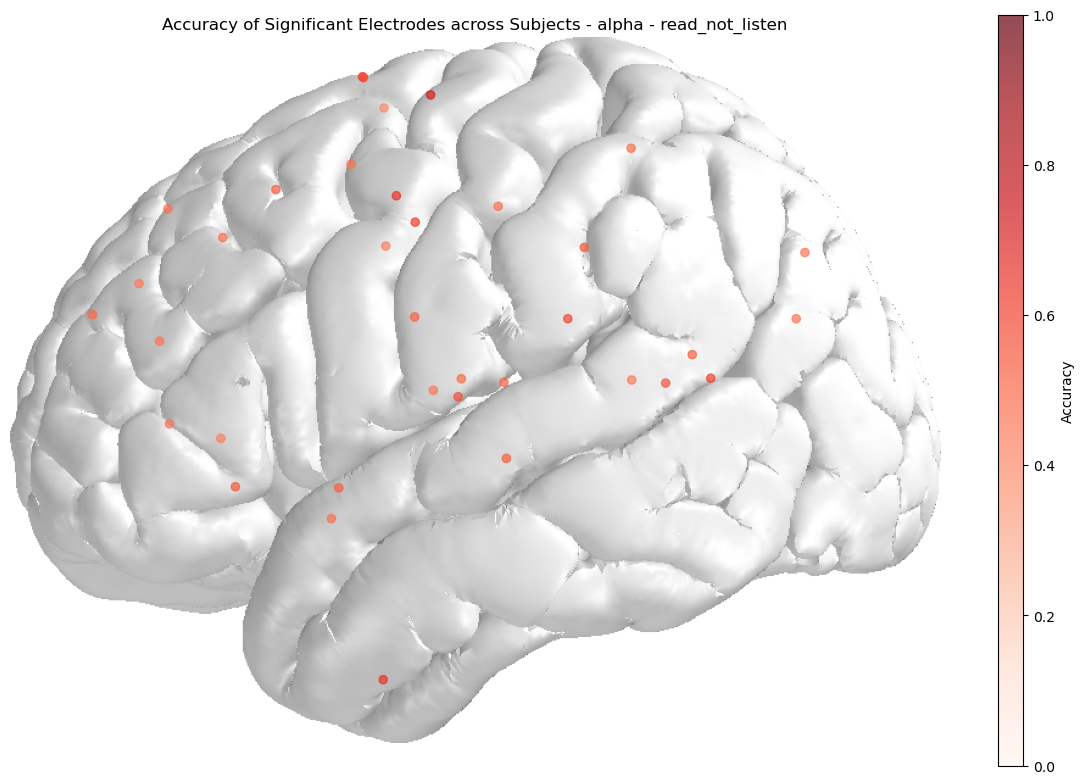

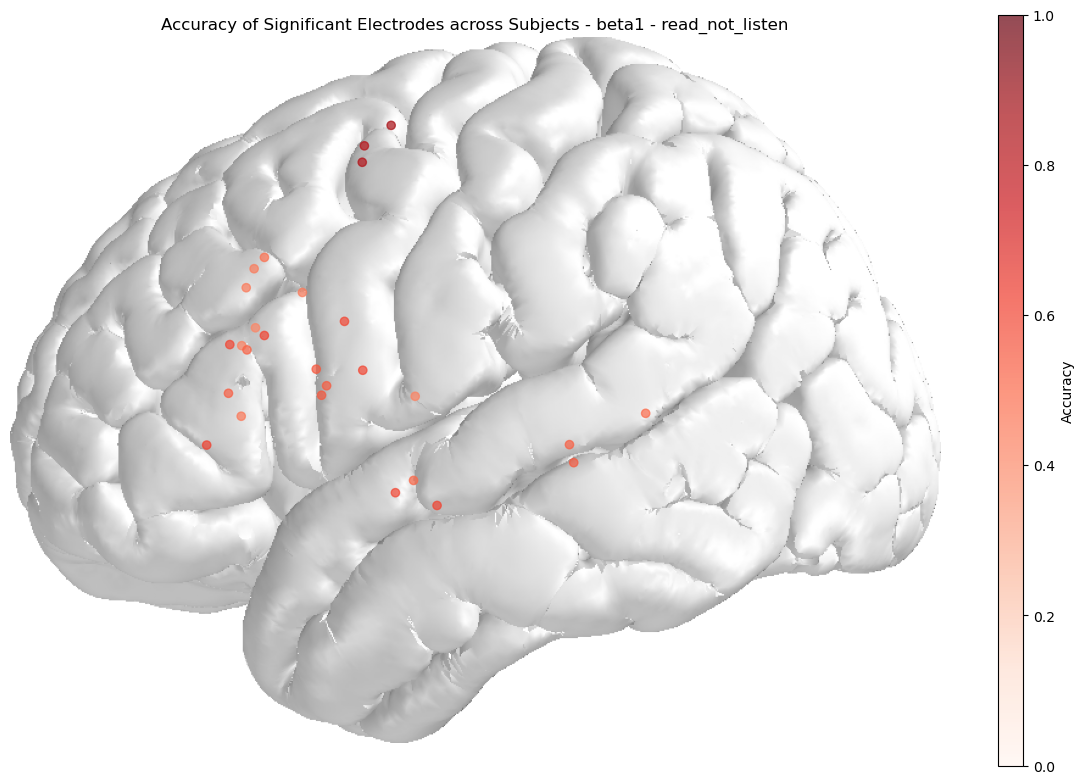

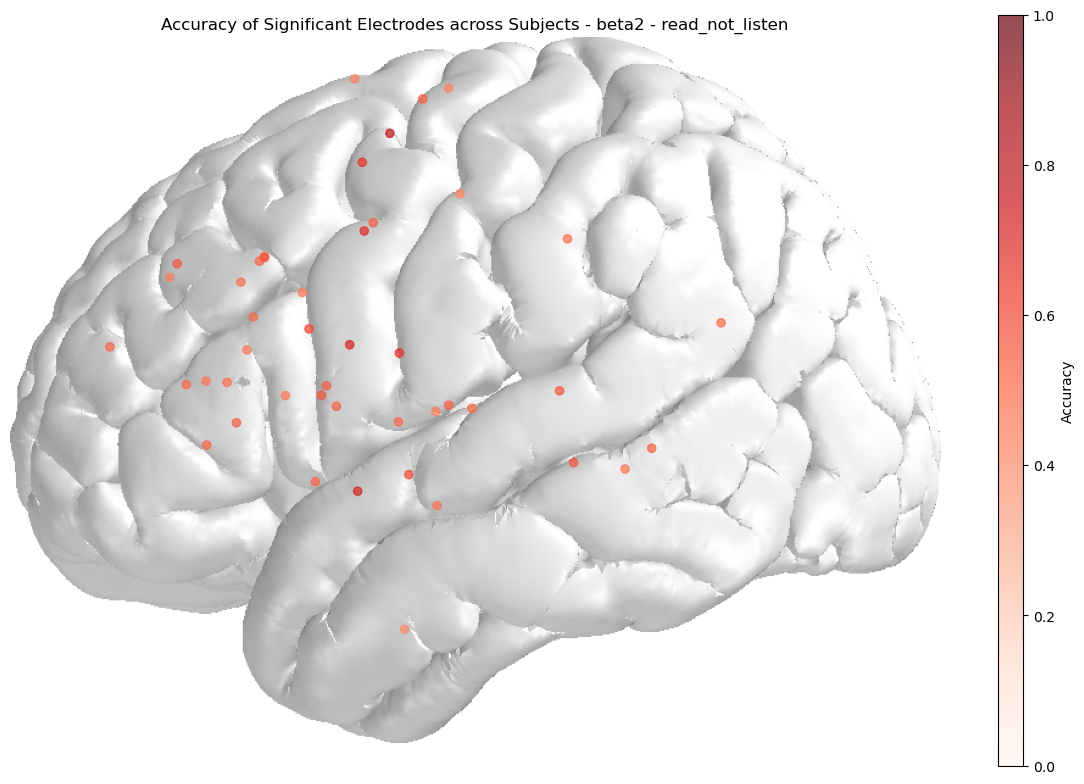

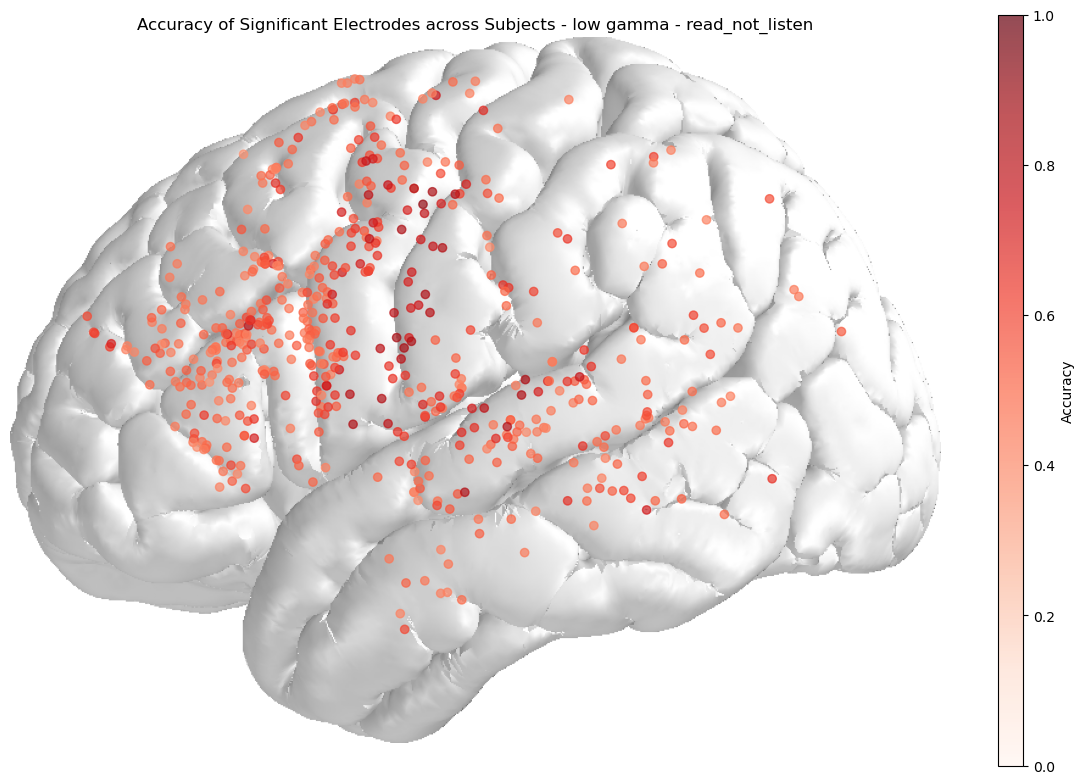

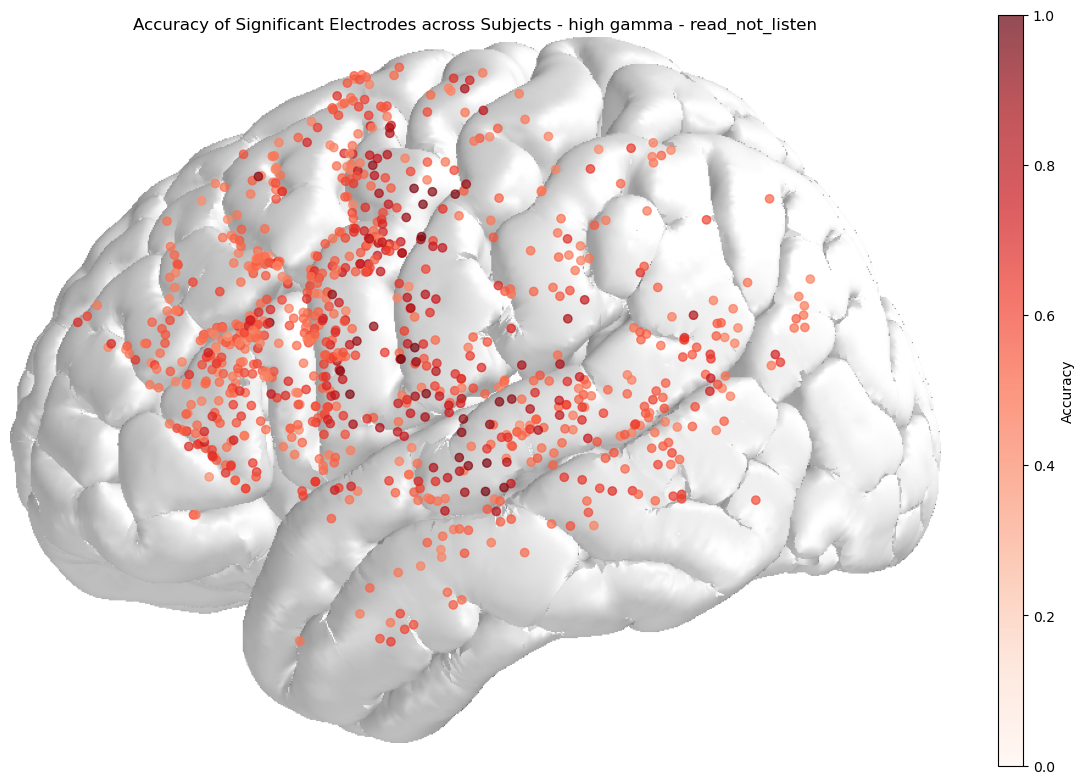

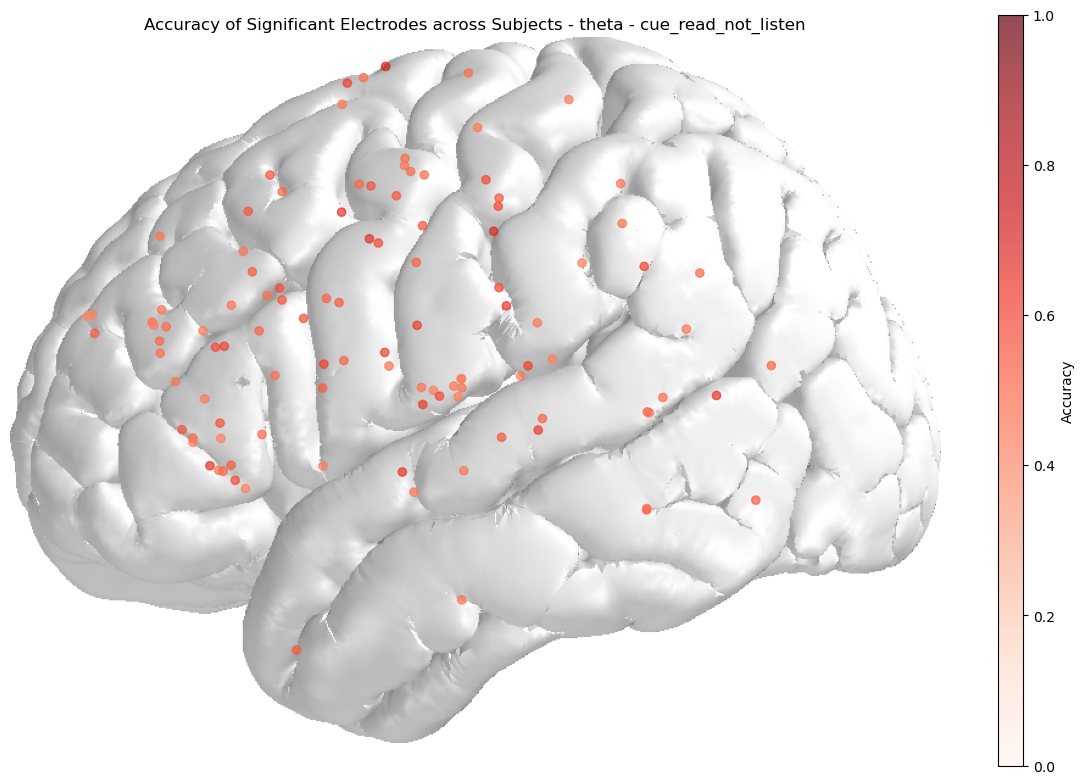

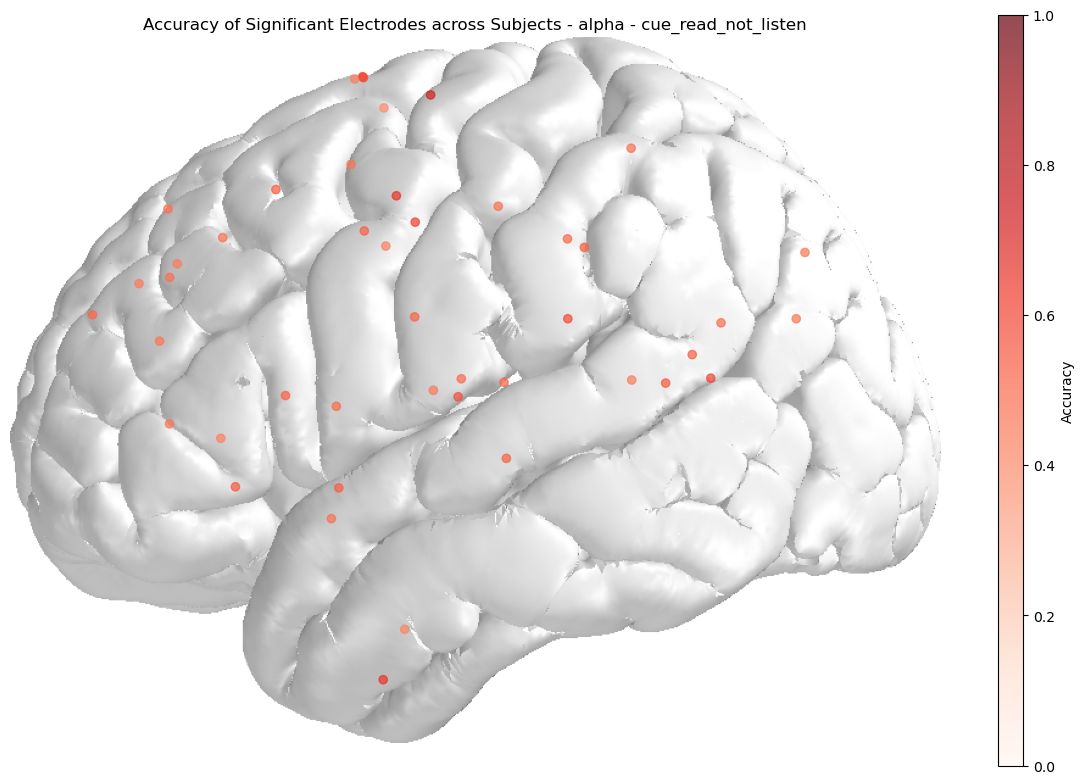

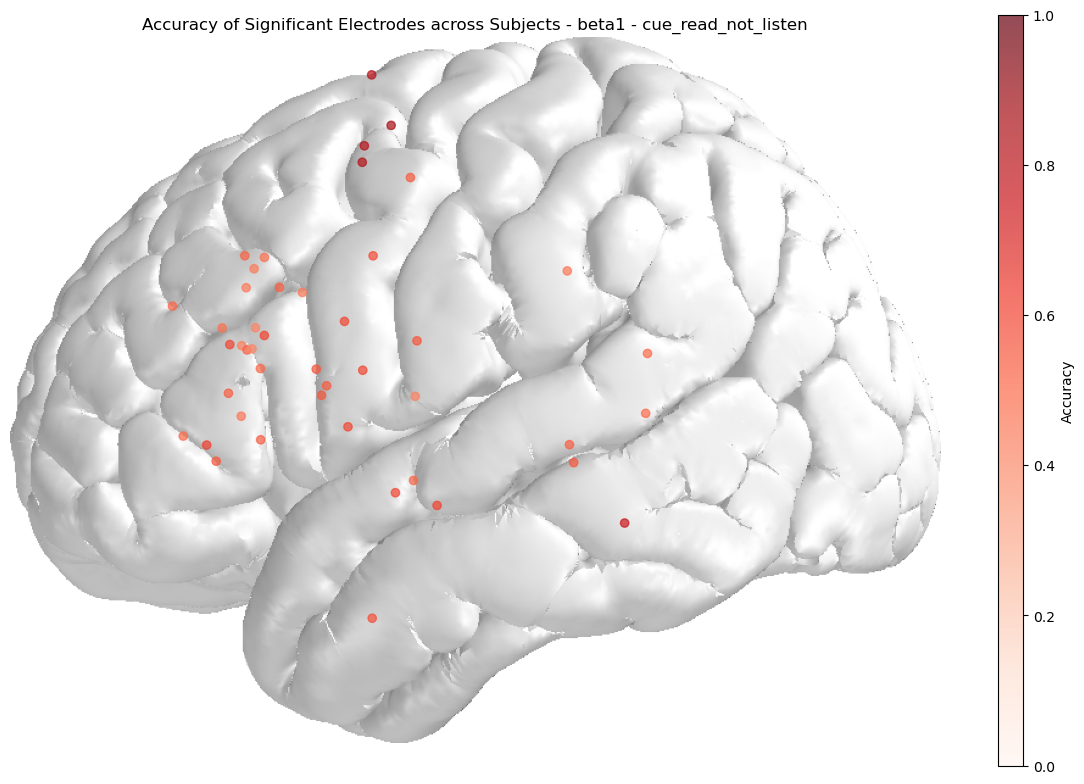

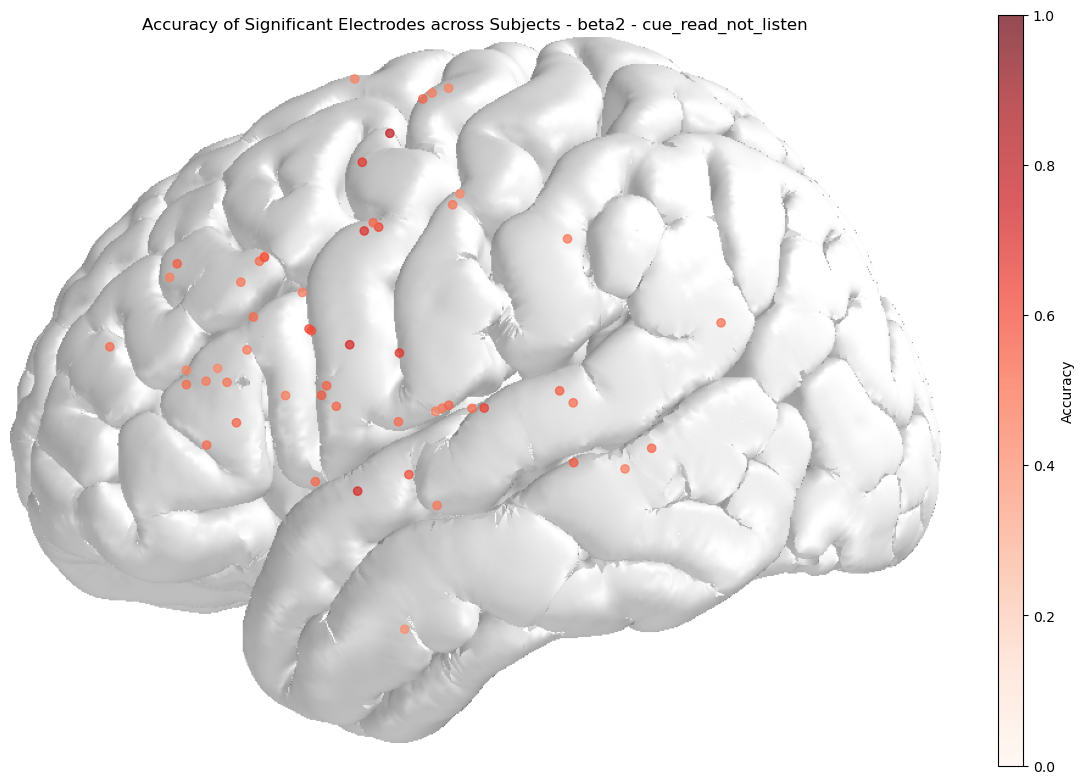

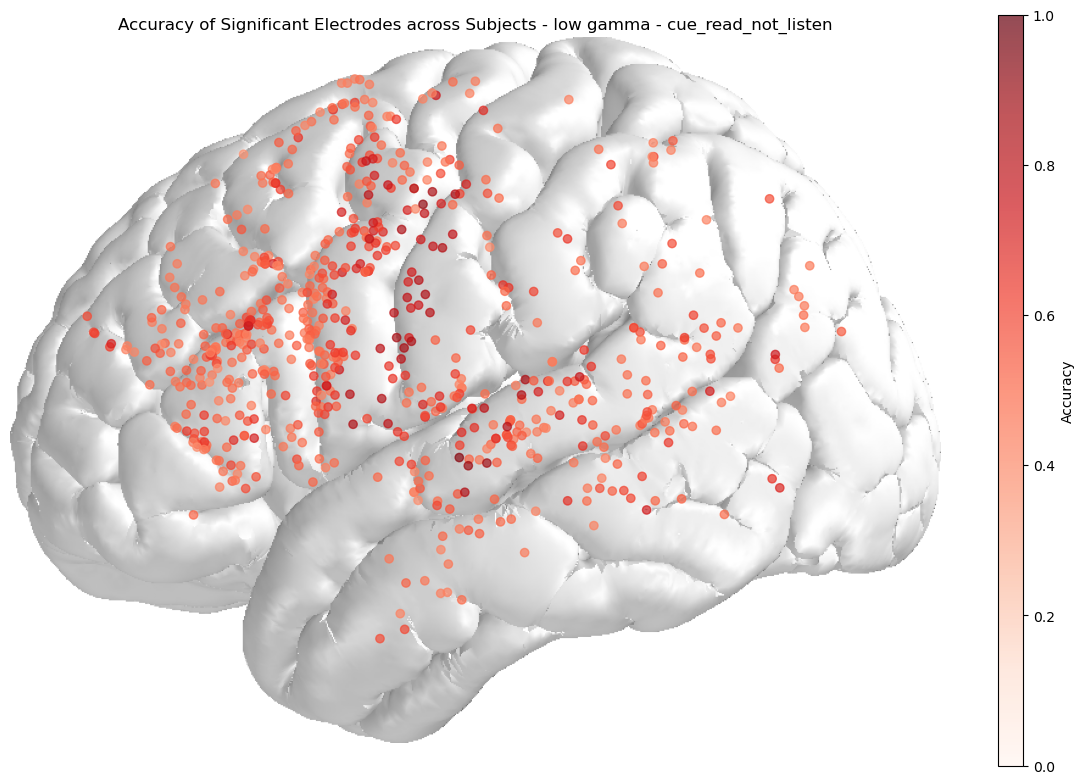

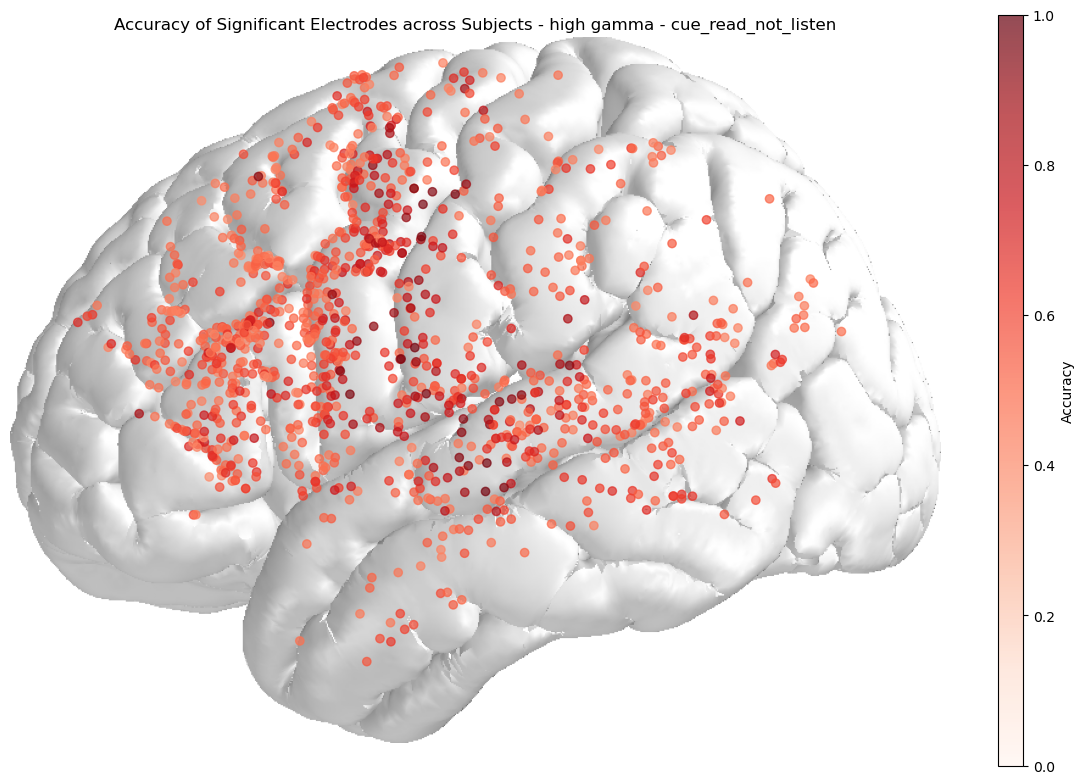

In [ ]:
save_base_path = '/public/DATA/overt_reading/t-test_results/'
task_sigelecs = np.load(os.path.join(save_base_path, 'sig_elecs_not_in_listen.npy'), allow_pickle=True).item()

allHS_sigeles = {}
for task in task_sigelecs:
    allHS_sigeles[f'{task}'] = {}
    for band in bands_list:
        band_sigelecs = []
        for HS in HS_list:
            bands_sig_elecs = task_sigelecs[task][f'HS{HS}'][band]
            for elec in bands_sig_elecs:
                band_sigelecs.append(elec)
        allHS_sigeles[f'{task}'][band] = band_sigelecs
        print(band_sigelecs)

for task in task_sigelecs:
    for band in bands_list:
        all_coords, all_values = load_all_subjects_acc_of_sig(HS_list, freq_list, allHS_sigeles[f'{task}'][band], band)
        # print(all_coords)
        if(len(all_coords) == 0):
            continue
        # Plot accuracy on brain surface
        plot_brain_surface_with_acc(all_coords, all_values, band, task)

## 1.6 plot accuracy heatmap for different brain regions across different frequency bands

In [26]:
import os
import numpy as np
import scipy.io as scio
import seaborn as sns
import matplotlib.pyplot as plt

def load_band_acc(save_acc_dir, band, task=None):
    """加载指定频段和任务的准确率"""
    if task is None:
        bands_acc = np.load(os.path.join(save_acc_dir, 'bands_acc.npy'), allow_pickle=True).item()
    elif task == 'Cue':
        bands_acc = np.load(os.path.join(save_acc_dir, 'bands_acc_cue.npy'), allow_pickle=True).item()
    elif task == 'Read':
        bands_acc = np.load(os.path.join(save_acc_dir, 'bands_acc_read.npy'), allow_pickle=True).item()
    return bands_acc[band]

def calculate_region_accuracy(HS_list, bands_list, freq_list, save_acc_dir, task_sigelecs):
    """统计每个脑区的电极并计算准确率"""
    region_acc = {}  # 存储每个脑区的准确率信息
    # for task in task_sigelecs:
    #     for HS in HS_list:
    #         bands_sig_elecs = task_sigelecs[task][f'HS{HS}']
    for subject_str in HS_list:
        anatomy = scio.loadmat(f"/public/DATA/overt_reading/elecs/All_elecs/HS{subject_str}_elecs_all_warped.mat")['anatomy']
        for freq in freq_list:
            save_acc_dir_HS = os.path.join(save_acc_dir, f'HS{subject_str}/{freq}')
            for band in bands_list:
                # 加载该被试的所有电极的准确率
                overall_acc = load_band_acc(save_acc_dir_HS, band, task=None)
                Cue_acc = load_band_acc(save_acc_dir_HS, band, task='Cue')
                overt_acc = load_band_acc(save_acc_dir_HS, band, task='Read')
                band_sig_elecs = task_sigelecs[f'HS{HS}'][band]

                # 遍历每个电极，获取其脑区标签并累计统计信息 并只记录显著的电极
                for elec in range(len(overall_acc)):
                    if elec not in band_sig_elecs:
                        continue
                    region = anatomy[elec][3][0]  # 获取电极对应的脑区标签

                    if region not in region_acc:
                        region_acc[region] = {'Overall': {b: [] for b in bands_list},
                                            'Cue': {b: [] for b in bands_list},
                                            'Read': {b: [] for b in bands_list}}

                    for task in ['Overall', 'Cue', 'Read']:
                        if not isinstance(region_acc[region][task][band], list):
                            region_acc[region][task][band] = []
                            
                    # 累计该电极的准确率
                    region_acc[region]['Overall'][band].append(overall_acc[elec])
                    region_acc[region]['Cue'][band].append(Cue_acc[elec])
                    region_acc[region]['Read'][band].append(overt_acc[elec])

        # 计算每个脑区在不同任务和频段的平均准确率
        for region in region_acc:
            for task in region_acc[region]:
                for band in region_acc[region][task]:
                    region_acc[region][task][band] = np.mean(region_acc[region][task][band])

    return region_acc

def plot_region_accuracy_heatmap(region_acc, region_name, bands_list):
    """绘制指定脑区的准确率热图"""
    tasks = ['Overall', 'Cue', 'Read']
    data = []

    for task in tasks:
        data.append([region_acc[region_name][task][band] for band in bands_list])

    data = np.array(data)  # 转为二维数组
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(data, annot=True, xticklabels=bands_list, yticklabels=tasks, cmap='coolwarm', cbar_kws={'label': 'Accuracy'}, ax=ax)

    ax.set_xlabel("Frequency Bands")
    ax.set_ylabel("Tasks")
    ax.set_title(f"Accuracy Heatmap for {region_name}")

    plt.tight_layout()
    plt.show()


/root/anaconda3/envs/ecog/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/ecog/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


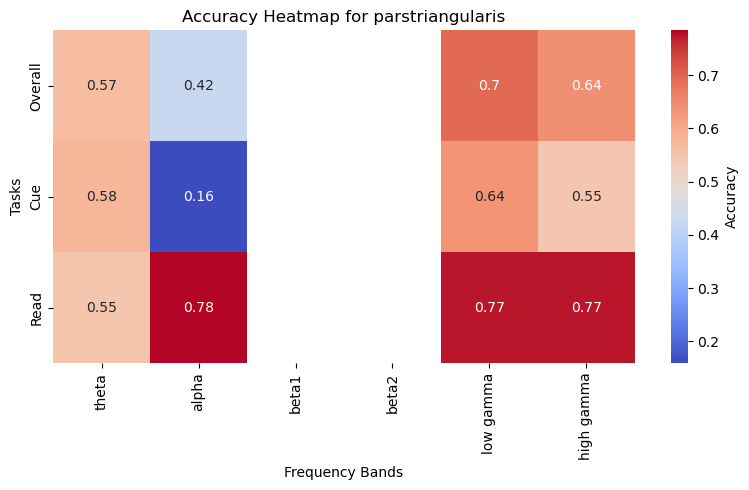

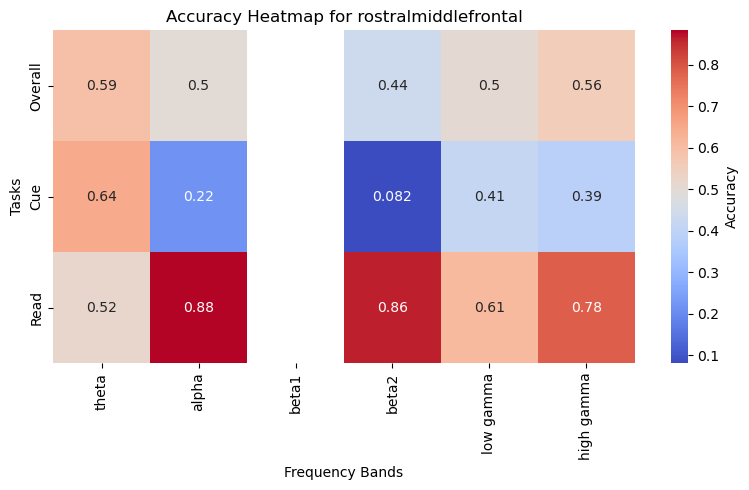

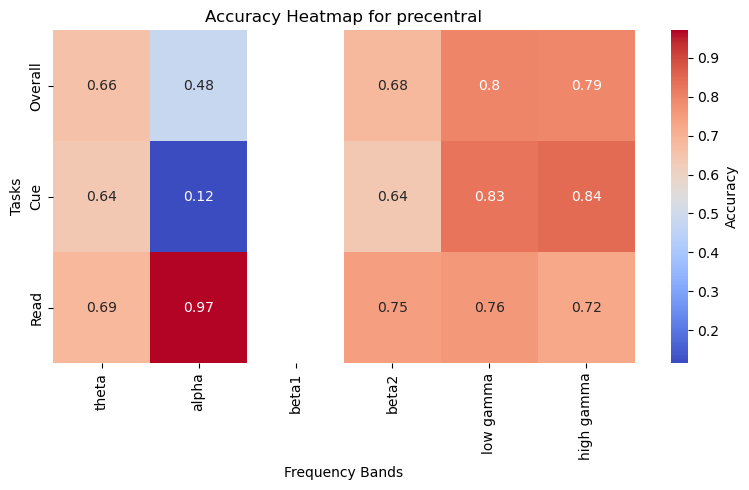

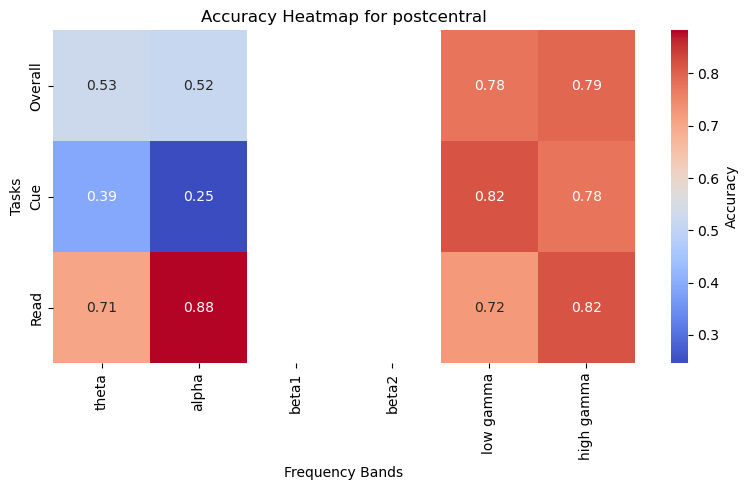

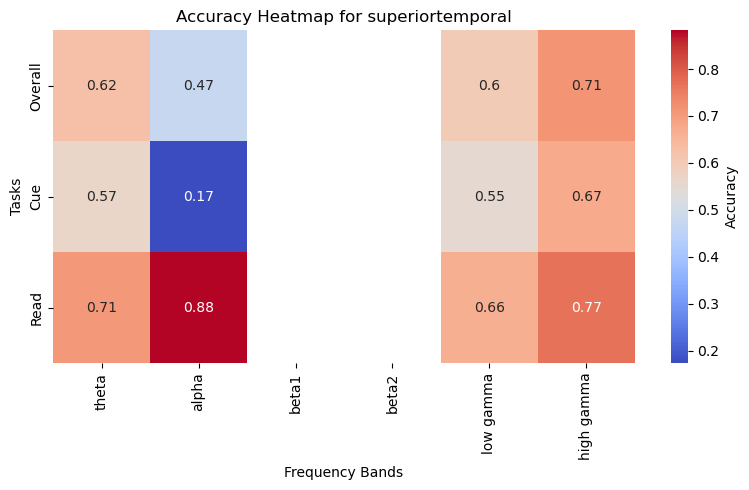

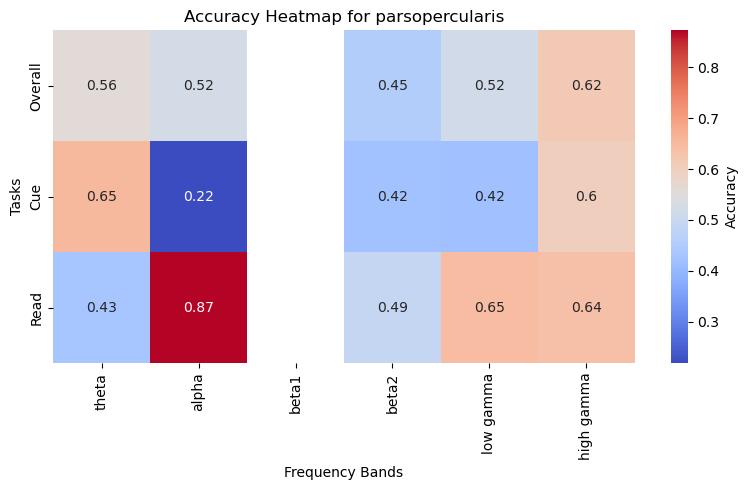

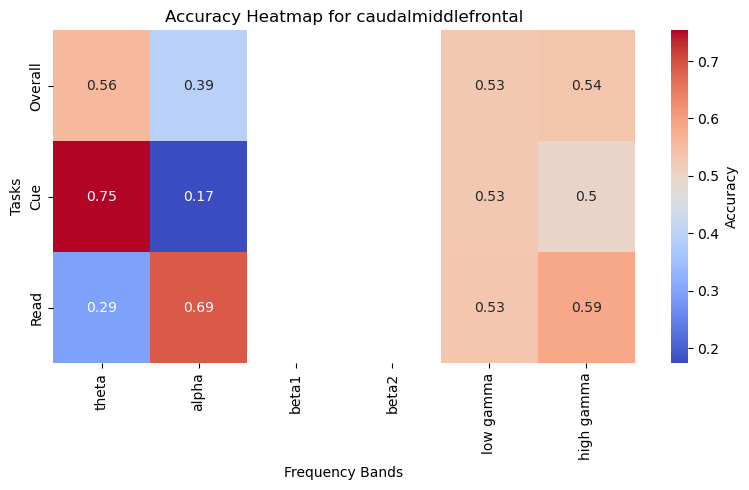

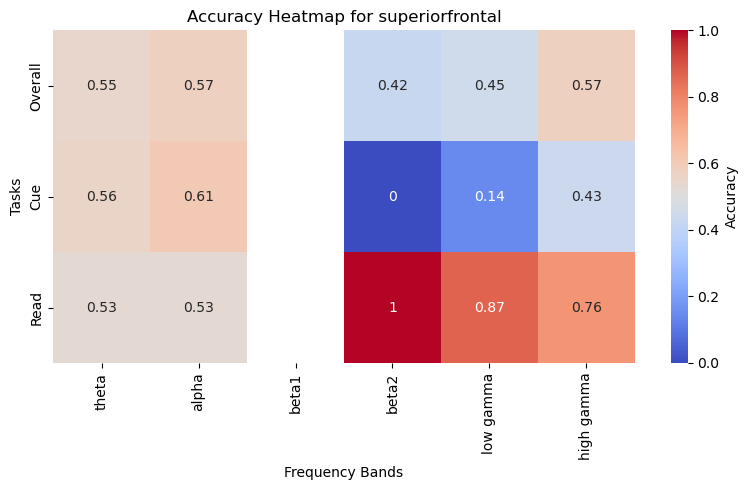

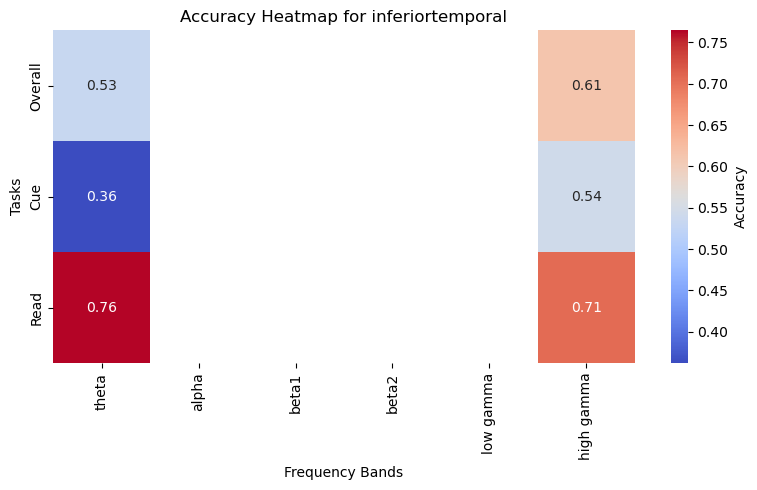

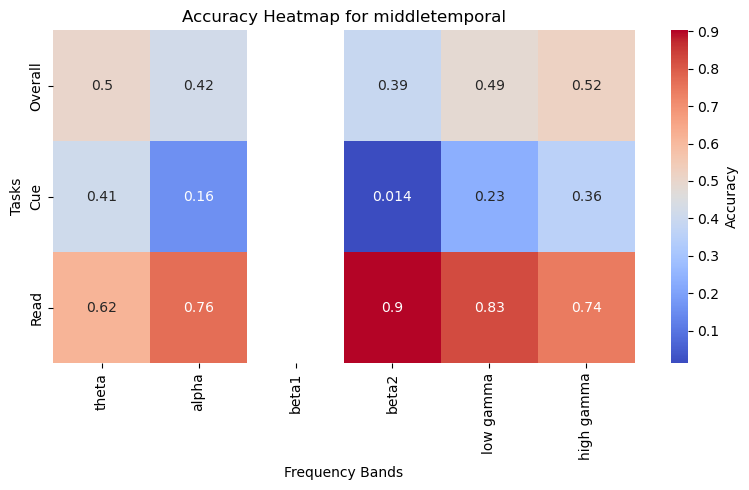

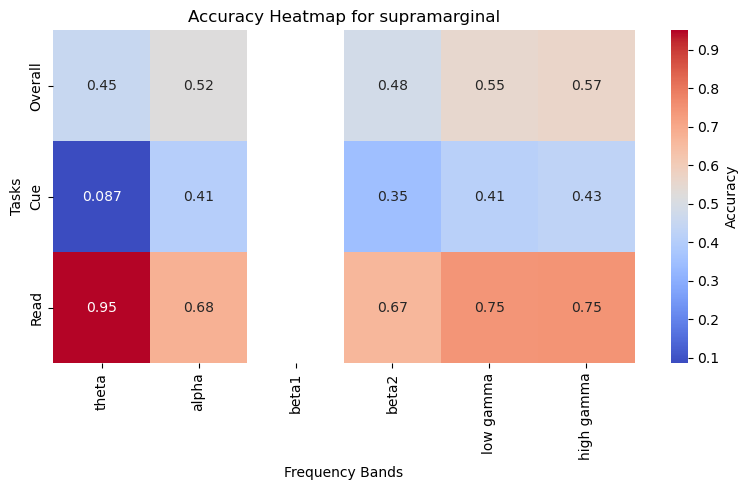

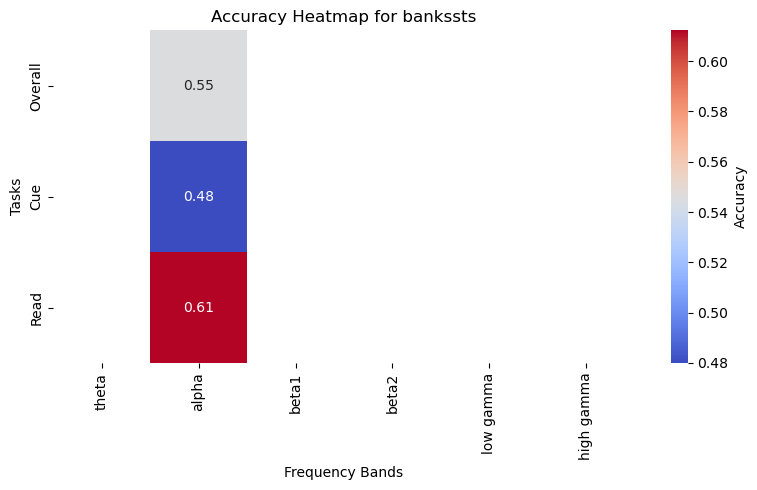

In [27]:
save_base_path = '/public/DATA/overt_reading/t-test_results/'
alltask_sigelecs = np.load(os.path.join(save_base_path, 'sig_elecs_not_in_listen.npy'), allow_pickle=True).item()
save_acc_dir = f'/public/DATA/overt_reading/bands_acc/'
region_acc = calculate_region_accuracy(HS_list, bands_list, freq_list, save_acc_dir, alltask_sigelecs['cue_read_not_listen'])
for region in region_acc.keys():
    plot_region_accuracy_heatmap(region_acc, region, bands_list)